# Carpages.ca Webscraper
In this project, I will show you how to build a webscraper which scrapes car listing data from the website carpages.ca using python.

In [1]:
# Lets import the necessary libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd

## Accessing the Website
Before scraping a webpage you need to make sure that you can actually access the website. This is done by using the requests library and ensuring the [code status of the http request](https://docs.python.org/3/library/http.html) is 200. If you're webscraping and you get a code other than 200 you may need to consider alternative methods.

In [2]:
website = "https://www.carpages.ca/used-cars/search/?category_id=5"
response = requests.get(website)
status = response.status_code
status

200

Perfect the status code is 200 for carpages.ca meaning we can access the data using beautiful soup.

## Using Inspect Element to See How Car Listing Data is Displayed on Webpage
Before we continue we need to take a look at how carpages.ca organizes the data on its website. Here's a snippet of some listings on the webpage for new and used sedans
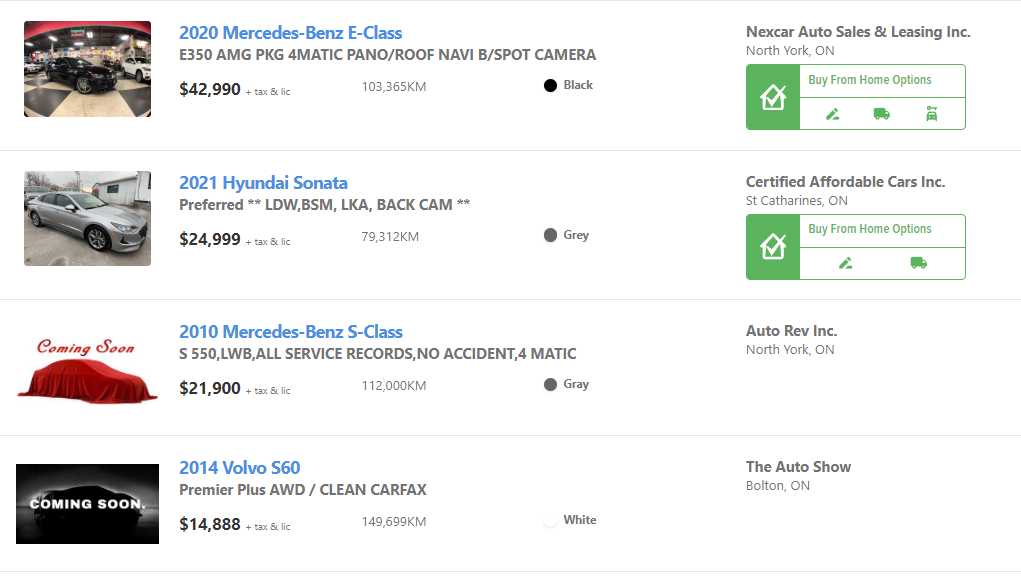

Looking at the website the listings contains the following useful data
* Title of listing
* Model of Vehicle
* Mileage (Km)
* Price (in CAD)
* Location
* Colour
* Image listing
* Dealership

Lets apply inspect element and took at how each of the carpage data is listed
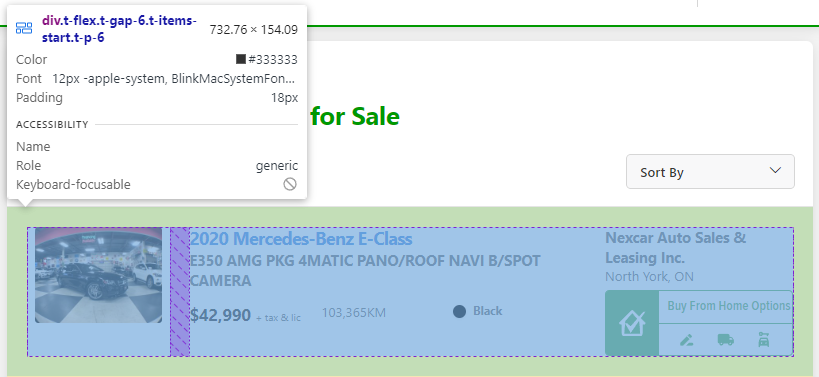

Looking at the html source code we can see that every listing is organized within a 'div' tab

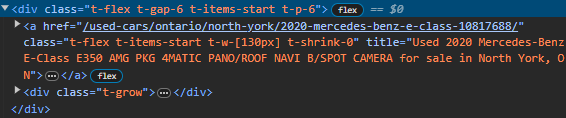

If we wish to gain additional data we need to parse through each of these tabs using Beautiful Soup

## Obtaining Data From html Tags
Lets collect all the car listings as beautiful soup elements

In [3]:
soup = BeautifulSoup(response.content,'html.parser')
cars = soup.find_all('div', class_='t-flex t-gap-6 t-items-start t-p-6')
len(cars)

50

As desired we have obtained 50 div elements, one for each of the listings. Now that we have all of the div elements for each of the listings we need to look through the html code and find important key data that's worth scraping.

## Relevant Data in each listing

* Titles - "Title of the listing"
* Year - Year of manufacturing for the model
* Model - Model of the vehicle
* Style - Style correpsonds to body type of the cat (ex. Sedan, SUV)
* Condition - Used or New
* Price - Price in Canadian dollars
* Mileage - Mileage in Kilometres
* Dealer - Dealership of the vehicle
* City - City in which car is located in
* Province - Canadian province the car is listed in
* Posting Link - Link for personal listing page
* Image Link - Link for posting image

Now that we know what data we're interested in we can use some html and python knowledge to obtain each of these fields

#### Getting Title, Condition, Year, Model, Make, City and Province

In [4]:
car = cars[0].findAll("a")
title = car[0].find("img").get("alt")
title

'Used 2019 Ford Fusion Hybrid Hybrid,Certified,New Winter Tires & Brakes,GPS for sale in Kitchener, ON'

Conveniently for us the title contains the condition, year,city and province.

In [5]:
# The year, model, make, city and province are located within the title and can be obtained using list and string operations
titleInfo = title.split(" ")
condition = titleInfo[0]
year = titleInfo[1]
make = titleInfo[2]
province = titleInfo[-1]
titleInfo

['Used',
 '2019',
 'Ford',
 'Fusion',
 'Hybrid',
 'Hybrid,Certified,New',
 'Winter',
 'Tires',
 '&',
 'Brakes,GPS',
 'for',
 'sale',
 'in',
 'Kitchener,',
 'ON']

In [6]:
city = cars[0].findAll("p", class_="hN")[0].text.split(", ").pop(0)
city

'Kitchener'

#### Getting the Model, Price, and Dealer


In [7]:
model = cars[0].findAll("a")[1].text
model

'2019 Ford Fusion Hybrid'

Lets obtain the price

In [8]:
price = list(filter(lambda a: a != "",str(cars[0].find("span").text).split(" ")))[-1] 
price = price[1:len(price)]
price = price.replace(",","")
price

'19999'

Lets obtain the dealer data

In [9]:
dealer = cars[0].findAll("h5")[-1].text
dealer

'Auto Expo Inc.'

#### Getting the Mileage
Will take a bit more work since we need to do some error handling, sometimes on listing sites users can put CALL

In [10]:
def getMileage(car):
    mileage = ""
    mileageInfo = car.findAll("div",class_="t-col-span-full mobile-lg:t-col-span-6 laptop:t-col-span-4")[0].find_all("span")
    for m in mileageInfo:
        mileage += m.text
    try:
        mileage = int(mileage.replace(",","")[0:-2])
    except ValueError:
        # Sometimes posters will put text in place of a mileage so we need to account for error handling using a try statement 
        pass

    return mileage
getMileage(cars[0])

126000

In [11]:
colour = cars[0].find("span",class_="t-text-sm t-font-bold").text
colour

'Black'

#### Getting posting link data and image link data

In [14]:
image_link = cars[4].find_all("a")[0].find("img").get("data-original")
#posting_link = "https://www.carpages.ca"+cars[0].find("a").get("href")
#posting_link
image_link

'https://images.carpages.ca/inventory/10819941.389000304?w=320&h=240&q=75&s=2b614016d3a90b5536358f98385c53d9'

Now lets put everything together

In [88]:
def getMileage(car):
    # Inputs:
    # car(List) - List of tags for a one car listing on carpages.ca
    #
    # Outputs:
    # mileage(int/str) - mileage as string or integer
    #
    # Purpose:
    # Gets the mileage of one car listing
    mileage = ""
    mileageInfo = car.findAll("div",class_="t-col-span-full mobile-lg:t-col-span-6 laptop:t-col-span-4")[0].find_all("span")
    for m in mileageInfo:
        mileage += m.text
    try:
        mileage = int(mileage.replace(",","")[0:-2])
    except ValueError:
        # Sometimes posters will put text in place of a mileage so we need to account for error handling using a try statement 
        pass

    return mileage

def getPrice(car):
    # Inputs:
    # car(List) - List of tags for a one car listing on carpages.ca
    #
    # Outputs:
    # price(int/str) - price as string or integer
    #
    # Purpose:
    # Gets the price of one car listing
    price = list(filter(lambda a: a != "",str(car.find("span").text).split(" ")))[-1] 
    price = price[1:len(price)]
    price = price.replace(",","")
    try:
        price = float(price)
    except:
        ValueError
    return price

def ExtractPageData(website,bodyType):
    # Inputs:
    # website(str) - website of carpages.ca 
    # bodyType(int) - bodyType of vehicle based off of carpages.ca's indices as defined below in bodyTypes dict
    # 
    # Outputs:
    # pageData(pd) - pandas dataframe corresponding to all of the data saved for a carpages.ca listing
    #
    # Purpose:
    # Extracts all the car data on a given webpage  
    bodyTypes = {
        1:"Convertable",
        2:"Coupe",
        3:"Hatchback",
        4:"Hybrid/Electric",
        5:"Sedan",
        6:"SUV",
        7:"Crossover",
        8:"Van/Minivan",
        9:"Pickup Truck"}

    response = requests.get(website)
    status = response.status_code
    soup = BeautifulSoup(response.content,'html.parser')

    # desired fields as dictionary
    data = {
        "Titles" : [],
        "Year" : [],
        "Model" : [],
        "Make" : [],
        "Colour" : [],
        "Style" : bodyTypes[bodyType],
        "Condition" : [],
        "Price" : [],
        "Mileages" : [],
        "Dealer" : [],
        "City": [],
        "Province" : [],
        "Posting Link": [],
        "Image Link": [],
    }
    soup = BeautifulSoup(response.content,'html.parser')
    cars = soup.find_all('div', class_='t-flex t-gap-6 t-items-start t-p-6')

    # loop for every car on the webpage and append the values to the data dictionary above
    for car in cars:
        vec = car.findAll("a")
        title = vec[0].find("img").get("alt")
        info = title.split(" ")
        data["Titles"].append(title)
        data["Condition"].append(info[0])
        data["Year"].append(info[1])
        data["Make"].append(info[2])
        data["Model"].append(car.find_all("a")[1].text)
        data["Province"].append(car.findAll("p", class_="hN")[0].text.split(", ").pop(1))
        data["City"].append(car.findAll("p", class_="hN")[0].text.split(", ").pop(0))
        data["Dealer"].append(car.findAll("h5")[-1].text)
        data["Mileages"].append(getMileage(car))
        data["Price"].append(getPrice(car))
        data["Posting Link"].append("https://www.carpages.ca"+car.find("a").get("href"))
        data["Image Link"].append(car.find_all("a")[0].find("img").get("data-original"))
        data["Colour"].append(car.find("span",class_="t-text-sm t-font-bold").text)

    pageData = pd.DataFrame(data)
    return pageData

def ExtractPageRangeData(bodyType,currentPage,finalPage):
    # Inputs:
    # currentPage(int) - first page you wish to extract data from
    # finalPage(int) - last page you wish to extract data from
    # bodyType(int) - bodyType of vehicle based off of carpages.ca's indices (Sedan,SUV, etc...)
    # 
    # Outputs:
    # table(pd) - pandas dataframe corresponding to all of the data saved from carpages.ca between pages currentPage->finalPage for a vehicle of a body type 
    #
    # Purpose:
    # Extracts all the car data on a given webpage  
    tableOfData = []

    while currentPage <= finalPage:
        try:
            website = "https://www.carpages.ca/used-cars/search/?num_results=50&category_id="+str(bodyType)+"&p="+str(currentPage)
            tableOfData.append(ExtractPageData(website,bodyType))
            currentPage += 1
        except Exception:
            break

    table = pd.concat(tableOfData,ignore_index=True)
    return table

Lets collect 1000 entries of data for scraping

In [151]:
table = ExtractPageRangeData(5,1,100)

#### Applying the Scraper

In [152]:
import plotly.express as px

In [153]:
table.head()

,Titles,Year,Model,Make,Colour,Style,Condition,Price,Mileages,Dealer,City,Province,Posting Link,Image Link
0,Used 2015 Volkswagen Golf 5dr HB Auto 1.8 TSI ...,2015,2015 Volkswagen Golf,Volkswagen,Blue,Sedan,Used,13998.0,109344,H2H Auto Group,Surrey,BC,https://www.carpages.ca/used-cars/british-colu...,https://images.carpages.ca/inventory/10817976....
1,Used 2010 Honda Civic 4dr Auto DX-G for sale i...,2010,2010 Honda Civic,Honda,Black,Sedan,Used,5995.0,248500,ABC Auto Repairs,Kitchener,ON,https://www.carpages.ca/used-cars/ontario/kitc...,https://images.carpages.ca/inventory/10817967....
2,Used 2008 Honda Accord 4dr I4 Auto EX for sale...,2008,2008 Honda Accord,Honda,Grey,Sedan,Used,5995.0,199700,ABC Auto Repairs,Kitchener,ON,https://www.carpages.ca/used-cars/ontario/kitc...,https://images.carpages.ca/inventory/10817964....
3,Used 2012 Mazda MAZDA6 4DR SDN I4 AUTO GS for ...,2012,2012 Mazda MAZDA6,Mazda,Blue,Sedan,Used,6995.0,202000,ABC Auto Repairs,Kitchener,ON,https://www.carpages.ca/used-cars/ontario/kitc...,https://images.carpages.ca/inventory/10817958....
4,Used 2013 Acura ILX Tech Pkg for sale in Oakvi...,2013,2013 Acura ILX,Acura,,Sedan,Used,13990.0,136100,Twin Oaks Auto,Oakville,ON,https://www.carpages.ca/used-cars/ontario/oakv...,https://images.carpages.ca/inventory/10817952....


#### Analysis of Provinces

In [156]:
#provincePercents = round(100*(table["Province"].value_counts() / len(table)),2)
#provincePercents
provinceCounts = table["Province"].value_counts()
fig = px.pie(provinceCounts,values="Province",names=provinceCounts.index,title="Number of Car Listings By Province")
fig.show()

#### Findings on Provincial Data
Looking at a data set of ~5000 car postings, it's no surprise that the Ontario listings make up the highest portion of listings. We can see that Ontario is a bit overrepresented per capita, as we know from official sources that Ontarians account for 35% of the population. A suprising fact is that the despite Québec being the second most populous province in the country they only account for 2% of the car listings. It could be that Québecois have their own alternatives to carpages.ca that they prefer.  

In [163]:
CityCounts = table["City"].value_counts().head(10)
fig = px.pie(CityCounts,values="City",names=CityCounts.index,title="Number of Car Listings By Top 10 cities")
fig.show()

#### Discussion on City Data
As expected the majority of the top 10 cities are within an hour of the greater toronto area, the exception being Winnipeg, Surrey and Coquitlam. It's likely that Winnipeg is the top 3rd city as its a fairly populous suburban area with some need for cars.

In [171]:
MakeCounts = table["Colour"].value_counts().head(5)
fig = px.pie(MakeCounts,values="Colour",names=MakeCounts.index,title="Top 10 years for used cars ")
fig.show()

In [172]:
MakeCounts = table["Make"].value_counts().head(5)
fig = px.pie(MakeCounts,values="Make",names=MakeCounts.index,title="Top makes for used cars")
fig.show()

In [175]:
df = table["Price"]
fig = px.histogram(df, x="Price", nbins=500)
fig.show()

In [180]:
df = table["Mileages"]
fig = px.histogram(df, x="Mileages", nbins=1000)
fig.show()